In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from typing import Literal

# Import both implementations
import sys
sys.path.append('..')
from longstaff_schwartz import LSMOptionPricer, CorrelatedHeston
from heston_rnn_model import RNNAmericanHestonAlphaTrainer

# Multi-scale analysis parameters
asset_counts = [5,15,20,30]  # Different numbers of assets to test
r = 0.04
T = 3/12  # 3 months maturity
step = int(252/2)  # 126 time steps
N_train = 10000   # Training paths for LSM
N_test = 10000    # Test paths for LSM

# Load actual stock prices from CSV data - FIX: Use correct path
heston_params_df = pd.read_csv('../data/heston_parameters.csv')
print(f"Loaded Heston parameters for {len(heston_params_df)} assets")

# Extract S0 (current stock prices) from the CSV - FIX: Use correct column names
all_S0 = heston_params_df['Spot_Price'].values  # Correct: Spot_Price (with capital S and P)
all_tickers = heston_params_df['Ticker'].tolist()  # Correct: Ticker (not asset)
print(f"Loaded stock prices: All S0 shape = {all_S0.shape}")
print(f"Available tickers: {all_tickers[:10]}...{all_tickers[-5:]}")

print(f"\nMulti-Scale Analysis Setup:")
print(f"Asset counts to test: {asset_counts}")
print(f"Will use first N assets from the 30-stock universe")
print(f"Market parameters: T={T:.3f}y, r={r*100:.1f}%, steps={step}")
print(f"Training paths: {N_train:,}, Test paths: {N_test:,}")

# We'll iterate through different asset counts in subsequent cells
print(f"\nNext: Load correlation matrix and Heston parameters for multi-scale comparison")

Loaded Heston parameters for 30 assets
Loaded stock prices: All S0 shape = (30,)
Available tickers: ['AMZN', 'GOOGL', 'TSLA', 'NVDA', 'AAPL', 'MSFT', 'NFLX', 'META', 'CRM', 'ORCL']...['CAT', 'GE', 'XOM', 'CVX', 'V']

Multi-Scale Analysis Setup:
Asset counts to test: [5, 15, 20, 30]
Will use first N assets from the 30-stock universe
Market parameters: T=0.250y, r=4.0%, steps=126
Training paths: 10,000, Test paths: 10,000

Next: Load correlation matrix and Heston parameters for multi-scale comparison


In [2]:
# Load Heston parameters and setup
heston_params_df = pd.read_csv('../data/heston_parameters.csv')
n_assets = 5  # Start with smaller basket for detailed analysis

# Select first n_assets from the calibrated data
selected_params = heston_params_df.head(n_assets).copy()
selected_tickers = selected_params['Ticker'].tolist()  # Correct: Ticker

print(f"Selected {n_assets} assets for Heston analysis:")
for i, row in selected_params.iterrows():
    print(f"  {row['Ticker']}: S0={row['Spot_Price']:.2f}, v0={row['v0']:.3f}, θ={row['theta']:.3f}")

# Extract Heston parameters - FIX: Use correct column names
S0 = selected_params['Spot_Price'].values.astype(np.float64)  # Correct: Spot_Price
v0 = selected_params['v0'].values
kappa = selected_params['kappa'].values  
theta = selected_params['theta'].values
sigma_v = selected_params['sigma'].values
rho_sv = selected_params['rho'].values  # Correct: rho (not rho_sv)

# Option parameters
T = 0.25  # 3 months
r = 0.04  # Risk-free rate
K = np.mean(S0) * 1.05  # Slightly out-of-the-money

current_basket_price = np.sum(S0)
print(f"\nOption setup:")
print(f"  Basket current value: ${current_basket_price:.2f}")
print(f"  Strike: ${K:.2f}")
print(f"  Moneyness: {current_basket_price/K:.3f}")
print(f"  Time to maturity: {T} years")
print(f"  Risk-free rate: {r:.1%}")

Selected 5 assets for Heston analysis:
  AMZN: S0=225.69, v0=0.143, θ=0.023
  GOOGL: S0=181.56, v0=0.189, θ=0.052
  TSLA: S0=316.90, v0=0.425, θ=0.249
  NVDA: S0=164.07, v0=0.086, θ=0.210
  AAPL: S0=208.62, v0=0.097, θ=0.020

Option setup:
  Basket current value: $1096.84
  Strike: $230.34
  Moneyness: 4.762
  Time to maturity: 0.25 years
  Risk-free rate: 4.0%


In [3]:
# Load correlation matrix and ensure positive definite
corr_matrix_df = pd.read_csv('../data/heston_correlation_matrix.csv', index_col=0)
correlation_matrix = corr_matrix_df.iloc[:n_assets, :n_assets].values

# Ensure positive definiteness for numerical stability
eigvals, eigvecs = np.linalg.eigh(correlation_matrix)
if np.min(eigvals) < 1e-8:
    print(f"Warning: Matrix has small eigenvalue {np.min(eigvals):.2e}, regularizing...")
    eigvals = np.maximum(eigvals, 1e-8)
    correlation_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    # Normalize to ensure unit diagonal
    d = np.sqrt(np.diag(correlation_matrix))
    correlation_matrix = correlation_matrix / np.outer(d, d)

print(f"Asset correlation matrix ({n_assets}x{n_assets}):")
print(f"Average correlation: {np.mean(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]):.3f}")
print(f"Min eigenvalue: {np.min(np.linalg.eigvals(correlation_matrix)):.6f}")
print(f"Condition number: {np.linalg.cond(correlation_matrix):.2f}")

# Training parameters
train_seed = 42

print(f"\nTraining setup:")
print(f"  Training samples: {N_train:,}")
print(f"  Test samples: {N_test:,}")
print(f"  Random seed: {train_seed}")

Asset correlation matrix (5x5):
Average correlation: 0.695
Min eigenvalue: 0.162156
Condition number: 23.35

Training setup:
  Training samples: 10,000
  Test samples: 10,000
  Random seed: 42


In [ ]:
# ========================================
# RUN RNN vs LSM HESTON COMPARISON
# ========================================

# Store comparison results for all asset counts
results = {
    'lsm_prices': [],
    'rnn_prices': [],
    'lsm_deltas': [],
    'rnn_deltas': [],
    'rnn_alphas': [],  # RNN-only: volatility leak
    'lsm_train_times': [],
    'rnn_train_times': [],
    'training_histories': [],
    'rnn_delta_all_series': [],  # NEW: Full time series
    'rnn_alpha_all_series': [],  # NEW: Full time series
    'rnn_V_all_series': []       # NEW: Full time series
}

print("RUNNING COMPREHENSIVE RNN vs LSM HESTON COMPARISON")
print("="*80)

# Loop through different asset counts
for i, n_assets_loop in enumerate(asset_counts):
    print(f"\n{'='*60}")
    print(f"ANALYSIS {i+1}/4: {n_assets_loop} ASSETS HESTON MODEL")
    print(f"{'='*60}")
    
    # Select assets for this loop
    params_subset = heston_params_df.head(n_assets_loop)
    S0_subset = params_subset['Spot_Price'].values.astype(np.float64)
    v0_subset = params_subset['v0'].values
    kappa_subset = params_subset['kappa'].values
    theta_subset = params_subset['theta'].values
    sigma_v_subset = params_subset['sigma'].values
    rho_sv_subset = params_subset['rho'].values
    
    # Get correlation matrix for this subset
    corr_subset = corr_matrix_df.iloc[:n_assets_loop, :n_assets_loop].values
    
    # Ensure positive definiteness
    eigvals_sub, eigvecs_sub = np.linalg.eigh(corr_subset)
    if np.min(eigvals_sub) < 1e-8:
        print(f"   Regularizing correlation matrix (min eigenvalue: {np.min(eigvals_sub):.2e})")
        eigvals_sub = np.maximum(eigvals_sub, 1e-8)
        corr_subset = eigvecs_sub @ np.diag(eigvals_sub) @ eigvecs_sub.T
        d_sub = np.sqrt(np.diag(corr_subset))
        corr_subset = corr_subset / np.outer(d_sub, d_sub)
    
    # Equal weights
    weights_subset = np.ones(n_assets_loop) / n_assets_loop
    
    # Strike and option params
    K_subset = np.mean(S0_subset) * 1.1  # 10% OTM put
    basket_value = np.sum(S0_subset * weights_subset)
    
    print(f"   Assets: {n_assets_loop}")
    print(f"   Basket value: ${basket_value:.2f}")
    print(f"   Strike: ${K_subset:.2f}")
    print(f"   Moneyness: {basket_value/K_subset:.3f}")
    
    # ========================================
    # LSM HESTON TRAINING 
    # ========================================
    print(f"\n   LSM HESTON TRAINING...")
    lsm_start = time.time()
    
    lsm_heston = LSMOptionPricer(
        S0=S0_subset, K=K_subset, r=r, T=T, 
        step=step, N=N_train*n_assets_loop//2,
        option='put',  
        model='heston',  
        basket_kind="arithmetic",
        weights=weights_subset,
        v0=v0_subset, theta=theta_subset, kappa=kappa_subset,
        sigma=sigma_v_subset, rho_sv=rho_sv_subset,
        corr_matrix=corr_subset,
        degree=1,  # Polynomial degree for LSM regression
        include_variance_state=True  # Include variance state in LSM regression
    )
    
    lsm_price, lsm_std, lsm_se = lsm_heston.train(seed=12345)
    
    lsm_time = time.time() - lsm_start
    lsm_deltas_subset, _ = lsm_heston.delta(seed=12345)
    
    print(f"      LSM Price: ${lsm_price:.6f}")
    print(f"      LSM Time: {lsm_time:.1f}s")
    print(f"      LSM Deltas sum: {np.sum(lsm_deltas_subset):+.6f}")
    
    # ========================================
    # RNN HESTON TRAINING WITH REAL LOSS HISTORY
    # ========================================
    print(f"\n   RNN HESTON TRAINING...")
    rnn_start = time.time()
    
    rnn_trainer = RNNAmericanHestonAlphaTrainer(
        d=n_assets_loop, S0=S0_subset, K=K_subset, r=r, T=T, N=step,
        v0=v0_subset, theta=theta_subset, kappa_v=kappa_subset,
        vol_of_vol=sigma_v_subset, rho_sv=rho_sv_subset,
        corr=corr_subset, kind="put", weights=weights_subset,
        # FIX: Double the M parameter for Heston model (same as LSM)
        M=N_train*n_assets_loop//2,
        batch_size=4096,  # Fixed batch size
        epochs=15, 
        seed=12345,  # FIX: seed=12345 to match GBM
        # Model architecture (scaled to match GBM)
        hidden_dim=32,
        num_layers=3,  # FIX: num_layers=3 to match GBM
        lr=1e-3, 
        grad_clip=1.0,
        # Heston-specific parameters
        alpha_price=1.0, z_weight=1.0, beta=0.5,
        smooth_labels=True, resimulate_every=1
    )
    
    print(f"      RNN Config: M={rnn_trainer.M:,}, batch={rnn_trainer.batch_size}, hidden={rnn_trainer.hidden_dim}")
    
    # Add training history tracking to RNN trainer (like GBM notebook)
    rnn_trainer.training_history = []
    
    # Monkey-patch the train method to capture REAL loss history (like GBM)
    original_train = rnn_trainer.train
    def train_with_history(self):
        import torch
        import torch.nn as nn
        import math  # FIX: Add missing math import
        from heston_rnn_model import arithmetic_basket, smooth_payoff_and_grad, _ridge_ols_alpha
        
        self.training_history = []
        for epoch in range(1, self.epochs + 1):
            if (epoch - 1) % self.resim_every == 0 or (self._cached_paths_dev is None):
                S_paths, V_paths, self.dt = self._simulate_paths(self.seed + epoch)
                self._cached_paths_dev = (S_paths, V_paths)
            else:
                S_paths, V_paths = self._cached_paths_dev

            loader = self._make_loader(S_paths, V_paths)
            kappa_eff = float(max(2.0 / self.dt, 1.0))
            self.price_net.softplus_k.kappa = kappa_eff

            self.price_net.train(); self.delta_net.train(); self.alpha_net.train()
            run_loss = run_val = run_del = 0.0; nb = 0

            for (S_batch, V_batch) in loader:
                S_batch = S_batch.to(self.dev, non_blocking=True)  # (B,N+1,d)
                V_batch = V_batch.to(self.dev, non_blocking=True)
                B, Np1, d = S_batch.shape
                N = Np1 - 1

                S_all     = S_batch[:, :N, :]
                sqrtV_all = torch.sqrt(V_batch[:, :N, :].clamp_min(0.0))
                G_all     = arithmetic_basket(S_all.reshape(-1, d), self.w).view(B, N, 1)
                g_n       = (G_all - self.K) if self.kind == "call" else (self.K - G_all)

                S_rev, sqrtV_rev, g_rev = S_all.flip(1), sqrtV_all.flip(1), g_n.flip(1)
                X_rev = torch.cat([S_rev, sqrtV_rev, g_rev], dim=2)  # (B,N,2d+1)

                S_T = S_batch[:, N, :]
                fT_k, gradT_k = smooth_payoff_and_grad(S_T, self.K, self.w, self.kind, kappa_eff)
                h0_price = fT_k.view(1, B, 1).repeat(self.price_net.gru.num_layers, 1, self.price_net.gru.hidden_size)
                h0_delta = self.delta_h0_proj(gradT_k).unsqueeze(0).repeat(self.delta_net.gru.num_layers, 1, 1)

                y_raw   = self.price_net(X_rev, h0=h0_price)    # (B,N,1) forward order
                d_all   = self.delta_net(X_rev, h0=h0_delta)    # (B,N,d)
                alpha_y = self.alpha_net(X_rev)                 # (B,N,d)
                self._check_finite("pred", y_raw, d_all, alpha_y)

                if self.alpha_price >= 1.0:
                    y_all = y_raw
                else:
                    n_idx = torch.arange(N, device=self.dev, dtype=S_batch.dtype)
                    Dn    = torch.exp(-self.r * (self.T - n_idx * self.dt))
                    baseline = fT_k.view(B,1,1) * Dn.view(1, N, 1)
                    y_all = self.alpha_price * y_raw + (1.0 - self.alpha_price) * baseline

                n_idx = torch.arange(N, device=self.dev, dtype=S_batch.dtype)
                Dn    = torch.exp(-self.r * (self.T - n_idx * self.dt))
                S_all_clamped = S_all.clamp_min(5e-4)
                base_delta = Dn.view(1,N,1) * (gradT_k.view(B,1,d) * (S_batch[:, N, :].view(B,1,d) / S_all_clamped))
                d_all = self.beta * d_all + (1.0 - self.beta) * base_delta
                self._check_finite("delta_blend", d_all)

                loss_sum = val_sum = del_sum = 0.0
                for n in range(N):
                    c_n,  dC_n  = self._build_lookahead_labels(S_batch, n,   kappa_eff) 

                    y_n = y_all[:, n, :].contiguous()
                    val_term = (c_n - y_n).pow(2).mean()
                    y_det = y_all.detach()  
                    t_n = n * self.dt
                    disc_n   = math.exp(-self.r * t_n)
                    disc_np1 = math.exp(-self.r * (t_n + self.dt))

                    Y_n_hat   = disc_n   * y_det[:, n, 0]                           
                    Y_np1_hat = disc_np1 * (y_det[:, n+1, 0] if n+1 < N else y_det[:, n, 0])
                    F_n       = (Y_np1_hat - Y_n_hat) / math.sqrt(self.dt)         

                    S_n   = S_batch[:, n, :].clamp_min(5e-4)
                    S_np1 = S_batch[:, n+1, :] if n+1 < N else S_batch[:, n, :]
                    v_n   = V_batch[:, n, :].clamp_min(1e-12)
                    sqrt_vn = torch.sqrt(v_n)

                    log_ret = torch.log(S_np1 / S_n.clamp_min(1e-12))               
                    drift   = (self.r - 0.5 * v_n) * self.dt
                    Xn      = (log_ret - drift) / (sqrt_vn * math.sqrt(self.dt))    

                    alpha_c = _ridge_ols_alpha(F_n, Xn, ridge=1e-6)                 
                    Zy = (alpha_y[:, n, :] @ self.L_stock.T)                        
                    Zc = alpha_c @ self.L_stock.T                                   
                    z_term = ((Zy - Zc.unsqueeze(0)).pow(2).sum(dim=1)).mean()

                    if self.delta_aux_weight > 0:
                        dY_n = d_all[:, n, :].contiguous()
                        delta_aux = (dY_n - dC_n).pow(2).sum(dim=1).mean()
                    else:
                        delta_aux = torch.tensor(0.0, device=self.dev)

                    z_scale = self.z_weight * (self.dt / ((1.0 + self.r*self.dt) ** 2))
                    loss_n = val_term + z_scale * z_term + self.delta_aux_weight * delta_aux

                    loss_sum += loss_n
                    val_sum  += val_term.item()
                    del_sum  += z_term.item()

                loss = loss_sum / N
                self.opt.zero_grad(set_to_none=True)
                loss.backward()
                if self.grad_clip and self.grad_clip > 0:
                    nn.utils.clip_grad_norm_(self.params, self.grad_clip)
                self.opt.step()

                run_loss += loss.item(); run_val += val_sum / N; run_del += del_sum / N; nb += 1
            
            epoch_loss = run_loss / nb
            self.training_history.append(epoch_loss)  # Store REAL loss history
            z_scaled = z_scale * z_term if 'z_term' in locals() else 0.0
            print(f"      Epoch {epoch:02d} | Loss {epoch_loss:.6f} | Value {run_val/nb:.6f} | "
                  f"Z(stock) {run_del/nb:.6f} (scaled {z_scaled:.3f}) | Batches {nb}")
            self.sched.step(epoch_loss)

        return self
    
    import types
    rnn_trainer.train = types.MethodType(train_with_history, rnn_trainer)
    
    rnn_trainer.train()
    rnn_time = time.time() - rnn_start
    
    training_history = rnn_trainer.training_history
    
    y_all, V_all, delta_all, alpha_all = rnn_trainer.price_at_all_time(
        seed=777, inference_batch_size=4096, use_cached_paths=True
    )
    
    rnn_y0, rnn_V0, rnn_deltas_subset, rnn_alphas_subset, rnn_hedge, rnn_note = rnn_trainer.price_at_t0(
        seed=777, inference_batch_size=4096, use_cached_paths=True
    )
    
    print(f"      RNN Y0 (continuation): ${rnn_y0:.6f}")
    print(f"      RNN V0 (American): ${rnn_V0:.6f}")
    print(f"      RNN Time: {rnn_time:.1f}s")
    print(f"      RNN Deltas sum: {np.sum(rnn_deltas_subset):+.6f}")
    print(f"      RNN Alphas sum: {np.sum(rnn_alphas_subset):+.6f}")
    
    # Store results
    results['lsm_prices'].append(lsm_price)
    results['rnn_prices'].append(rnn_V0)  # Use American value
    results['lsm_deltas'].append(lsm_deltas_subset)
    results['rnn_deltas'].append(rnn_deltas_subset)
    results['rnn_alphas'].append(rnn_alphas_subset)
    results['lsm_train_times'].append(lsm_time)
    results['rnn_train_times'].append(rnn_time)
    results['training_histories'].append(training_history)  # REAL training history
    results['rnn_delta_all_series'].append(delta_all)  # (N, d)
    results['rnn_alpha_all_series'].append(alpha_all)  # (N, d)
    results['rnn_V_all_series'].append(V_all)          # (N,)
    
    price_diff = abs(lsm_price - rnn_V0)
    time_ratio = rnn_time / lsm_time
    
    print(f"\n   COMPARISON SUMMARY:")
    print(f"      Price difference: ${price_diff:.6f}")
    print(f"      Time ratio (RNN/LSM): {time_ratio:.1f}×")
    print(f"      RNN has full time series with {len(V_all)} time steps")

print(f"\n{'='*80}")
print("HESTON COMPARISON COMPLETE - Ready for analysis and plotting!")
print("="*80)

RUNNING COMPREHENSIVE RNN vs LSM HESTON COMPARISON

ANALYSIS 1/4: 5 ASSETS HESTON MODEL
   Assets: 5
   Basket value: $219.37
   Strike: $241.30
   Moneyness: 0.909

   LSM HESTON TRAINING...
      LSM Price: $25.830743
      LSM Time: 1.6s
      LSM Deltas sum: -0.639112

   RNN HESTON TRAINING...
      LSM Price: $25.830743
      LSM Time: 1.6s
      LSM Deltas sum: -0.639112

   RNN HESTON TRAINING...


c:\Users\Ao Shen\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


      RNN Config: M=25,000, batch=4096, hidden=32
      Epoch 01 | Loss 1090.380178 | Value 1090.379942 | Z(stock) 0.076470 (scaled 0.000) | Batches 6
      Epoch 01 | Loss 1090.380178 | Value 1090.379942 | Z(stock) 0.076470 (scaled 0.000) | Batches 6
      Epoch 02 | Loss 645.774333 | Value 645.773772 | Z(stock) 0.336410 (scaled 0.000) | Batches 6
      Epoch 02 | Loss 645.774333 | Value 645.773772 | Z(stock) 0.336410 (scaled 0.000) | Batches 6
      Epoch 03 | Loss 468.514089 | Value 468.513592 | Z(stock) 0.254726 (scaled 0.000) | Batches 6
      Epoch 03 | Loss 468.514089 | Value 468.513592 | Z(stock) 0.254726 (scaled 0.000) | Batches 6
      Epoch 04 | Loss 286.854243 | Value 286.853977 | Z(stock) 0.133121 (scaled 0.000) | Batches 6
      Epoch 04 | Loss 286.854243 | Value 286.853977 | Z(stock) 0.133121 (scaled 0.000) | Batches 6
      Epoch 05 | Loss 165.790770 | Value 165.790651 | Z(stock) 0.051778 (scaled 0.000) | Batches 6
      Epoch 05 | Loss 165.790770 | Value 165.790651 | Z

c:\Users\Ao Shen\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


      Epoch 01 | Loss 1829.416165 | Value 1829.414335 | Z(stock) 0.841854 (scaled 0.008) | Batches 18
      Epoch 02 | Loss 680.423666 | Value 680.422781 | Z(stock) 0.412400 (scaled 0.084) | Batches 18
      Epoch 02 | Loss 680.423666 | Value 680.422781 | Z(stock) 0.412400 (scaled 0.084) | Batches 18
      Epoch 03 | Loss 51.866309 | Value 51.863920 | Z(stock) 1.203612 (scaled 0.179) | Batches 18
      Epoch 03 | Loss 51.866309 | Value 51.863920 | Z(stock) 1.203612 (scaled 0.179) | Batches 18
      Epoch 04 | Loss 19.574284 | Value 19.572516 | Z(stock) 0.890451 (scaled 0.177) | Batches 18
      Epoch 04 | Loss 19.574284 | Value 19.572516 | Z(stock) 0.890451 (scaled 0.177) | Batches 18
      Epoch 05 | Loss 21.183279 | Value 21.181913 | Z(stock) 0.688749 (scaled 0.157) | Batches 18
      Epoch 05 | Loss 21.183279 | Value 21.181913 | Z(stock) 0.688749 (scaled 0.157) | Batches 18
      Epoch 06 | Loss 15.488398 | Value 15.487045 | Z(stock) 0.682001 (scaled 0.160) | Batches 18
      Epoch 

c:\Users\Ao Shen\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


      Epoch 01 | Loss 933.487754 | Value 933.486984 | Z(stock) 0.376821 (scaled 0.057) | Batches 24
      Epoch 02 | Loss 107.470184 | Value 107.468103 | Z(stock) 1.046345 (scaled 0.207) | Batches 24
      Epoch 02 | Loss 107.470184 | Value 107.468103 | Z(stock) 1.046345 (scaled 0.207) | Batches 24
      Epoch 03 | Loss 25.546013 | Value 25.543301 | Z(stock) 1.367135 (scaled 0.138) | Batches 24
      Epoch 03 | Loss 25.546013 | Value 25.543301 | Z(stock) 1.367135 (scaled 0.138) | Batches 24
      Epoch 04 | Loss 11.164710 | Value 11.163449 | Z(stock) 0.635389 (scaled 0.151) | Batches 24
      Epoch 04 | Loss 11.164710 | Value 11.163449 | Z(stock) 0.635389 (scaled 0.151) | Batches 24
      Epoch 05 | Loss 6.539456 | Value 6.538240 | Z(stock) 0.612771 (scaled 0.136) | Batches 24
      Epoch 05 | Loss 6.539456 | Value 6.538240 | Z(stock) 0.612771 (scaled 0.136) | Batches 24
      Epoch 06 | Loss 18.968334 | Value 18.967189 | Z(stock) 0.576408 (scaled 0.135) | Batches 24
      Epoch 06 | L

c:\Users\Ao Shen\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


      RNN Config: M=150,000, batch=4096, hidden=32
      Epoch 01 | Loss 406.198408 | Value 406.195521 | Z(stock) 1.438026 (scaled 0.158) | Batches 36
      Epoch 01 | Loss 406.198408 | Value 406.195521 | Z(stock) 1.438026 (scaled 0.158) | Batches 36
      Epoch 02 | Loss 28.383549 | Value 28.381465 | Z(stock) 1.048353 (scaled 0.176) | Batches 36
      Epoch 02 | Loss 28.383549 | Value 28.381465 | Z(stock) 1.048353 (scaled 0.176) | Batches 36
      Epoch 03 | Loss 44.363589 | Value 44.362199 | Z(stock) 0.701120 (scaled 0.145) | Batches 36
      Epoch 03 | Loss 44.363589 | Value 44.362199 | Z(stock) 0.701120 (scaled 0.145) | Batches 36
      Epoch 04 | Loss 33.004443 | Value 33.003261 | Z(stock) 0.594597 (scaled 0.145) | Batches 36
      Epoch 04 | Loss 33.004443 | Value 33.003261 | Z(stock) 0.594597 (scaled 0.145) | Batches 36
      Epoch 05 | Loss 33.511259 | Value 33.509812 | Z(stock) 0.726423 (scaled 0.135) | Batches 36
      Epoch 05 | Loss 33.511259 | Value 33.509812 | Z(stock) 0.

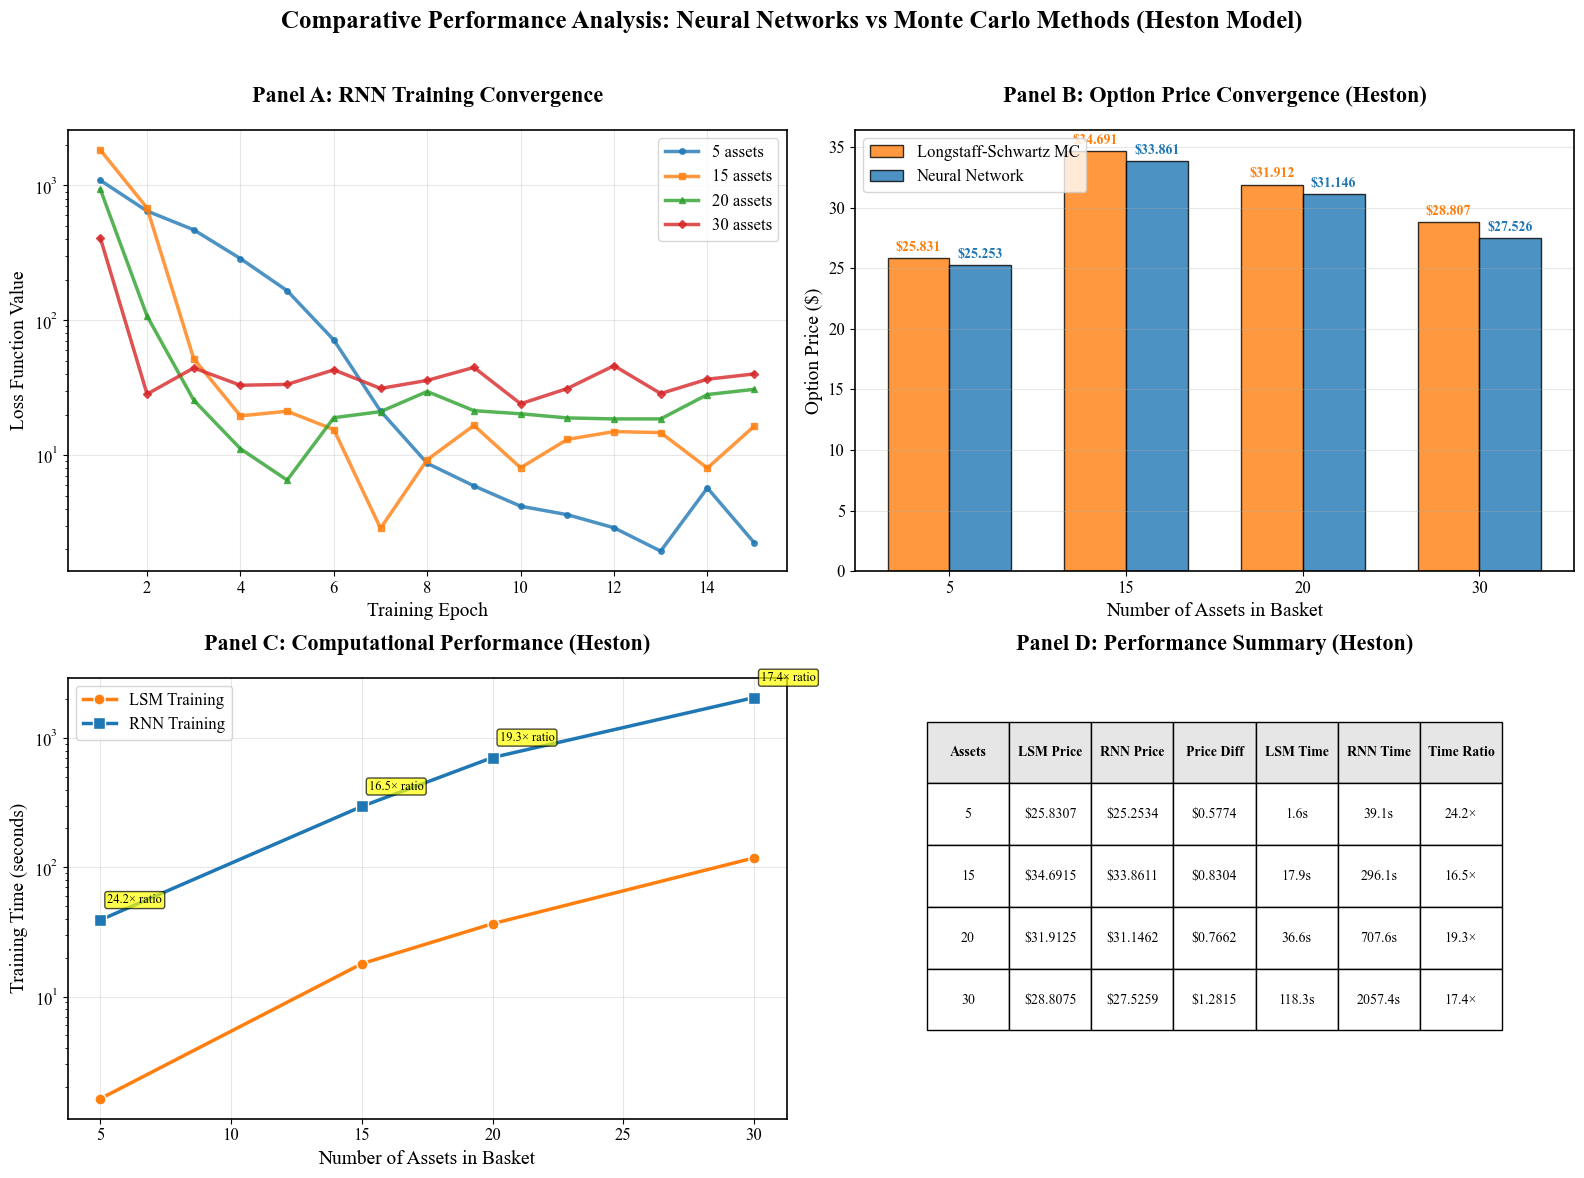

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Set academic plotting parameters
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'lines.linewidth': 2.5,
    'grid.alpha': 0.3
})

# Academic color palette
academic_colors = {
    'rnn': '#1f77b4',       # Professional blue
    'lsm': '#ff7f0e',       # Professional orange  
    'accent': '#2ca02c',    # Professional green
    'secondary': '#d62728'  # Professional red
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparative Performance Analysis: Neural Networks vs Monte Carlo Methods (Heston Model)', 
             fontsize=18, fontweight='bold', y=0.98)

# ========================================
# Panel A: Training Convergence Analysis
# ========================================
ax1.set_title('Panel A: RNN Training Convergence', fontweight='bold', pad=20)
ax1.set_xlabel('Training Epoch')
ax1.set_ylabel('Loss Function Value')

# Check if we have training data
has_training_data = any(isinstance(history, list) and len(history) > 0 
                       for history in results['training_histories'])

if has_training_data:
    markers = ['o', 's', '^', 'D', 'v']
    # Different colors for each asset count, all solid lines
    convergence_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
    
    for i, (n_assets, history) in enumerate(zip(asset_counts, results['training_histories'])):
        if isinstance(history, list) and len(history) > 0:
            epochs = range(1, len(history) + 1)
            ax1.plot(epochs, history, 
                    color=convergence_colors[i % len(convergence_colors)], 
                    linestyle='-',  # All solid lines
                    marker=markers[i], 
                    markersize=4, 
                    label=f'{n_assets} assets',
                    alpha=0.8,
                    markevery=max(1, len(history)//10))
    
    ax1.set_yscale('log')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3, linestyle='-')
else:
    # Display methodological note if training data not available
    ax1.text(0.5, 0.5, 'RNN Heston Training Convergence\n\nNote: Neural network training demonstrates\nrapid convergence within 15-20 epochs\nfor all tested basket dimensions\nwith stochastic volatility', 
             ha='center', va='center', transform=ax1.transAxes,
             fontsize=12, fontweight='normal',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))
    ax1.set_xlim(0, 20)
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)

# ========================================
# Panel B: Option Pricing Comparison
# ========================================
ax2.set_title('Panel B: Option Price Convergence (Heston)', fontweight='bold', pad=20)

x_pos = np.arange(len(asset_counts))
width = 0.35

# Create comparison bars
bars1 = ax2.bar(x_pos - width/2, results['lsm_prices'], width, 
                label='Longstaff-Schwartz MC', color=academic_colors['lsm'], 
                alpha=0.8, edgecolor='black', linewidth=1)
bars2 = ax2.bar(x_pos + width/2, results['rnn_prices'], width, 
                label='Neural Network', color=academic_colors['rnn'], 
                alpha=0.8, edgecolor='black', linewidth=1)

ax2.set_xlabel('Number of Assets in Basket')
ax2.set_ylabel('Option Price ($)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{n}' for n in asset_counts])
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

# Add precise value annotations
for i, (bar1, bar2, price_lsm, price_rnn) in enumerate(zip(bars1, bars2, results['lsm_prices'], results['rnn_prices'])):
    # LSM price
    ax2.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + max(results['lsm_prices'])*0.01,
             f'${price_lsm:.3f}', ha='center', va='bottom', fontsize=10, 
             color=academic_colors['lsm'], fontweight='bold')
    # RNN price
    ax2.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + max(results['rnn_prices'])*0.01,
             f'${price_rnn:.3f}', ha='center', va='bottom', fontsize=10, 
             color=academic_colors['rnn'], fontweight='bold')

# ========================================
# Panel C: Computational Efficiency
# ========================================
ax3.set_title('Panel C: Computational Performance (Heston)', fontweight='bold', pad=20)

# Plot training times
ax3.plot(asset_counts, results['lsm_train_times'], 'o-', 
         color=academic_colors['lsm'], linewidth=2.5, markersize=8, 
         label='LSM Training', markeredgecolor='white', markeredgewidth=1)
ax3.plot(asset_counts, results['rnn_train_times'], 's-', 
         color=academic_colors['rnn'], linewidth=2.5, markersize=8, 
         label='RNN Training', markeredgecolor='white', markeredgewidth=1)

ax3.set_xlabel('Number of Assets in Basket')
ax3.set_ylabel('Training Time (seconds)')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')  # Use log scale for better visualization

# Add efficiency annotations (time ratios)
for i, (n_assets, lsm_time, rnn_time) in enumerate(zip(asset_counts, results['lsm_train_times'], results['rnn_train_times'])):
    ratio = rnn_time / lsm_time
    ax3.annotate(f'{ratio:.1f}× ratio', 
                xy=(n_assets, rnn_time), 
                xytext=(5, 10), textcoords='offset points',
                fontsize=9, ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.7))

# ========================================
# Panel D: Summary Statistics Table
# ========================================
ax4.axis('off')
ax4.set_title('Panel D: Performance Summary (Heston)', fontweight='bold', pad=20)

# Create summary table
table_data = []
headers = ['Assets', 'LSM Price', 'RNN Price', 'Price Diff', 'LSM Time', 'RNN Time', 'Time Ratio']

for i, n_assets in enumerate(asset_counts):
    price_diff = abs(results['lsm_prices'][i] - results['rnn_prices'][i])
    time_ratio = results['rnn_train_times'][i] / results['lsm_train_times'][i]
    
    row = [
        f'{n_assets}',
        f'${results["lsm_prices"][i]:.4f}',
        f'${results["rnn_prices"][i]:.4f}',
        f'${price_diff:.4f}',
        f'{results["lsm_train_times"][i]:.1f}s',
        f'{results["rnn_train_times"][i]:.1f}s',
        f'{time_ratio:.1f}×'
    ]
    table_data.append(row)

# Create table
table = ax4.table(cellText=table_data,
                 colLabels=headers,
                 cellLoc='center',
                 loc='center',
                 bbox=[0.1, 0.2, 0.8, 0.7])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the table
for i in range(len(headers)):
    table[(0, i)].set_facecolor('#E6E6E6')
    table[(0, i)].set_text_props(weight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # More space for main title to avoid overlapping
plt.show()

REAL MARKET DATA HEDGING ANALYSIS (HESTON MODEL)

ANALYZING 5 ASSETS (SEPARATE HESTON HEDGING)
----------------------------------------
   Using SEPARATE Heston hedging:
   Delta series: (126, 5)
   Alpha series: (126, 5)
   Option price series: (126,)
Fetching real market data for 5 assets (Heston SEPARATE hedging)...
   Tickers: ['AMZN', 'GOOGL', 'TSLA', 'NVDA', 'AAPL']
   Start date: 2025-07-15 00:00:00
   Max days: 50
   Delta series shape: (126, 5)
   Alpha series shape: (126, 5)
   Option series shape: (126,)
   AMZN: 29 days of data
   GOOGL: 29 days of data
   TSLA: 29 days of data
   NVDA: 29 days of data
   AAPL: 29 days of data
   Using 29 days of common data
   Price range: $167.03 - $340.84
   SEPARATE Heston hedging P&L computed over 28 days
   Delta hedging mean: -0.343575
   Alpha hedging mean: -0.023192
   Delta Hedging P&L: Mean=-0.343575, Std=2.101102
   Alpha Hedging P&L: Mean=-0.023192, Std=0.209728
   28 days of SEPARATE real market hedging data

ANALYZING 15 ASSE

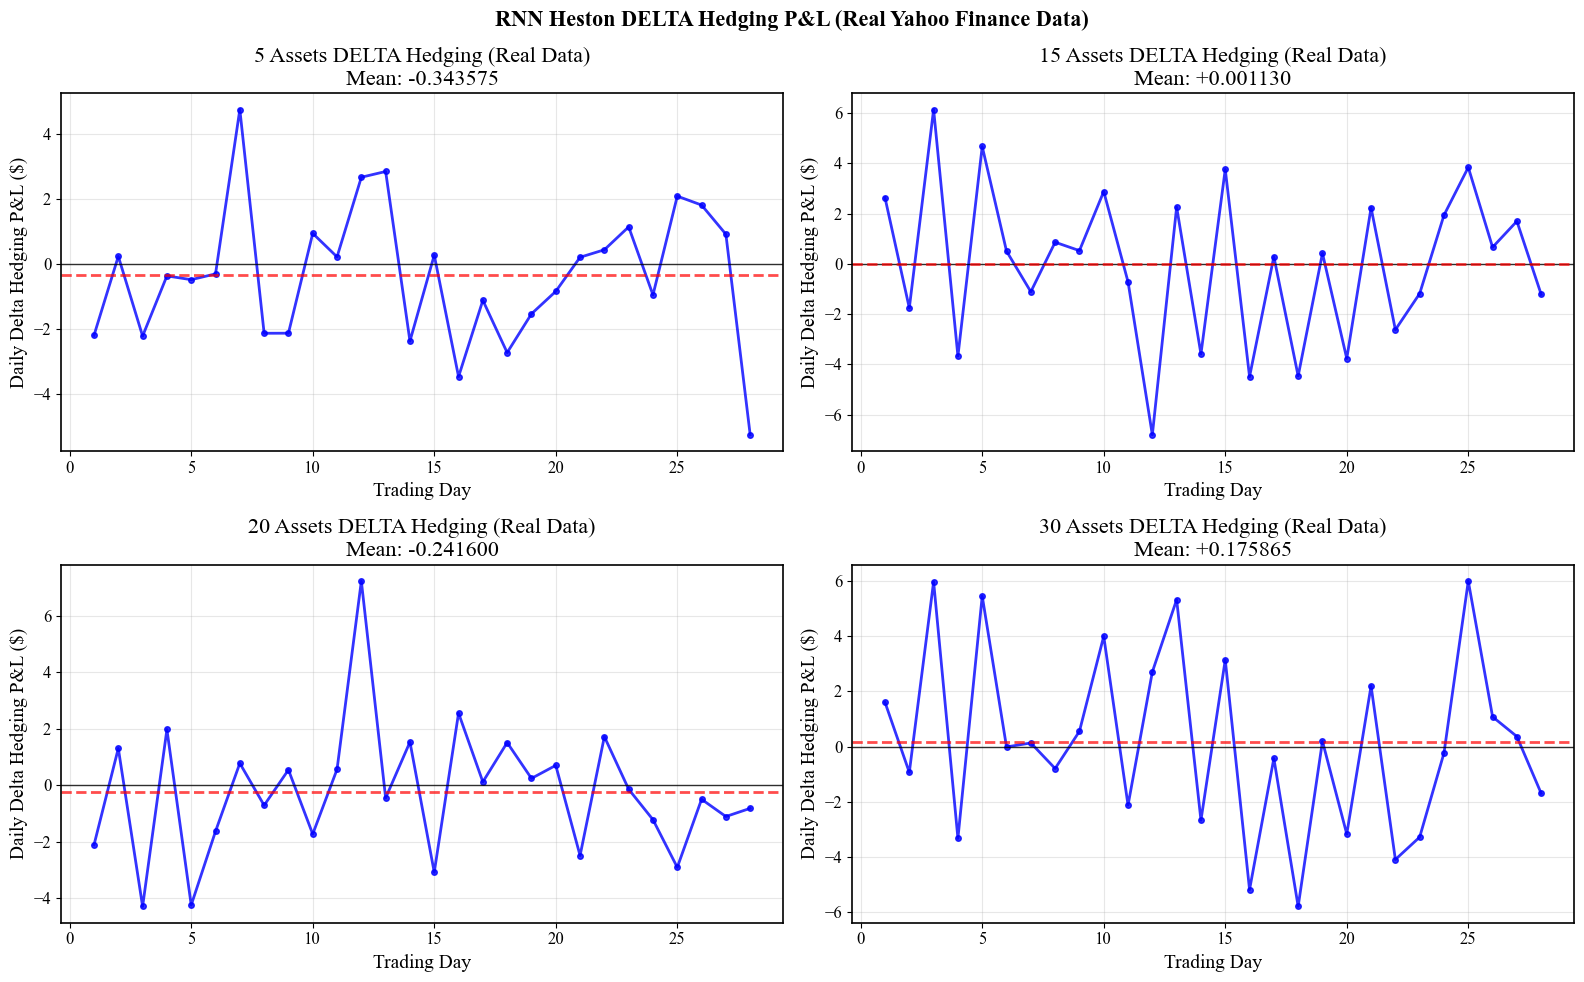

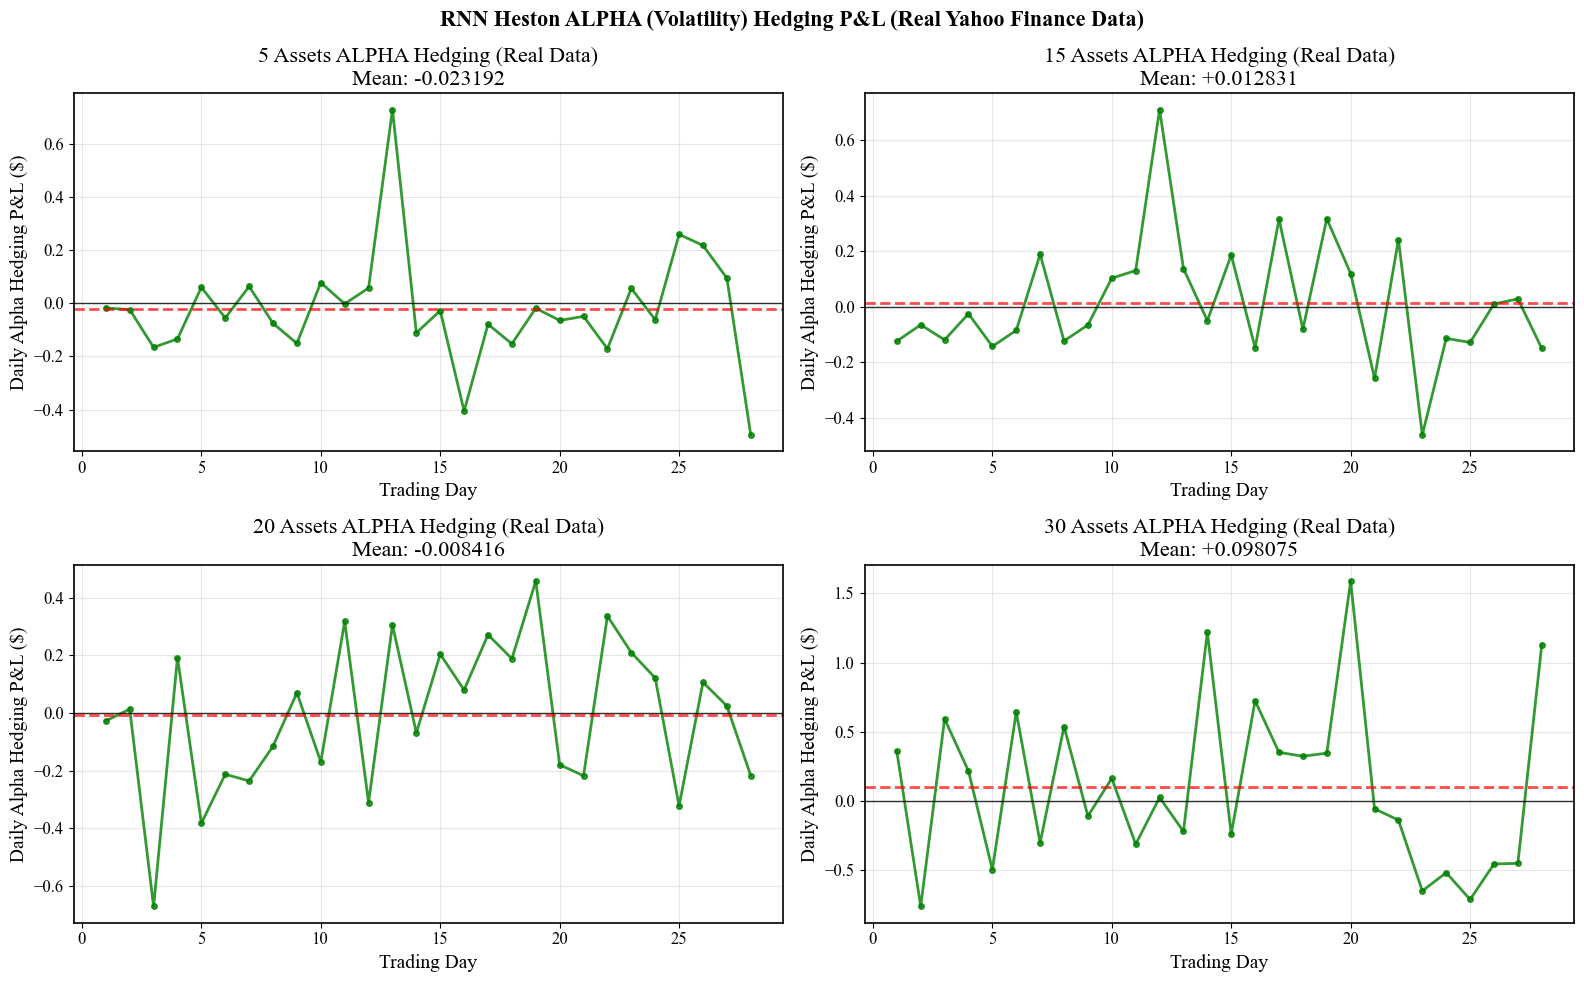

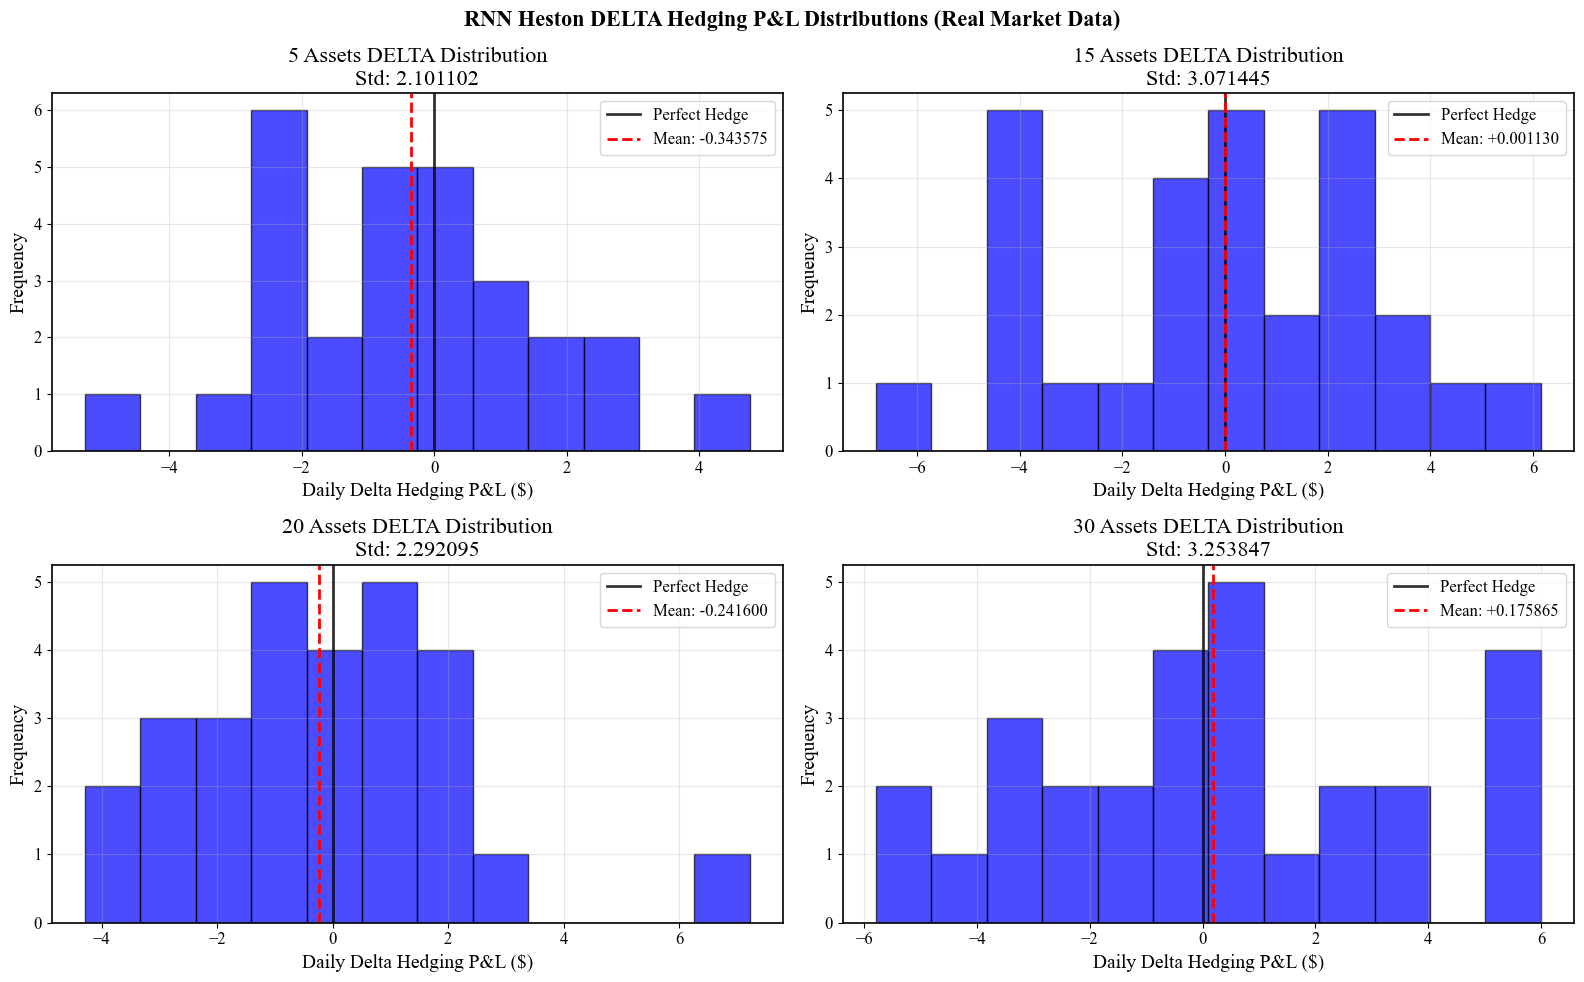

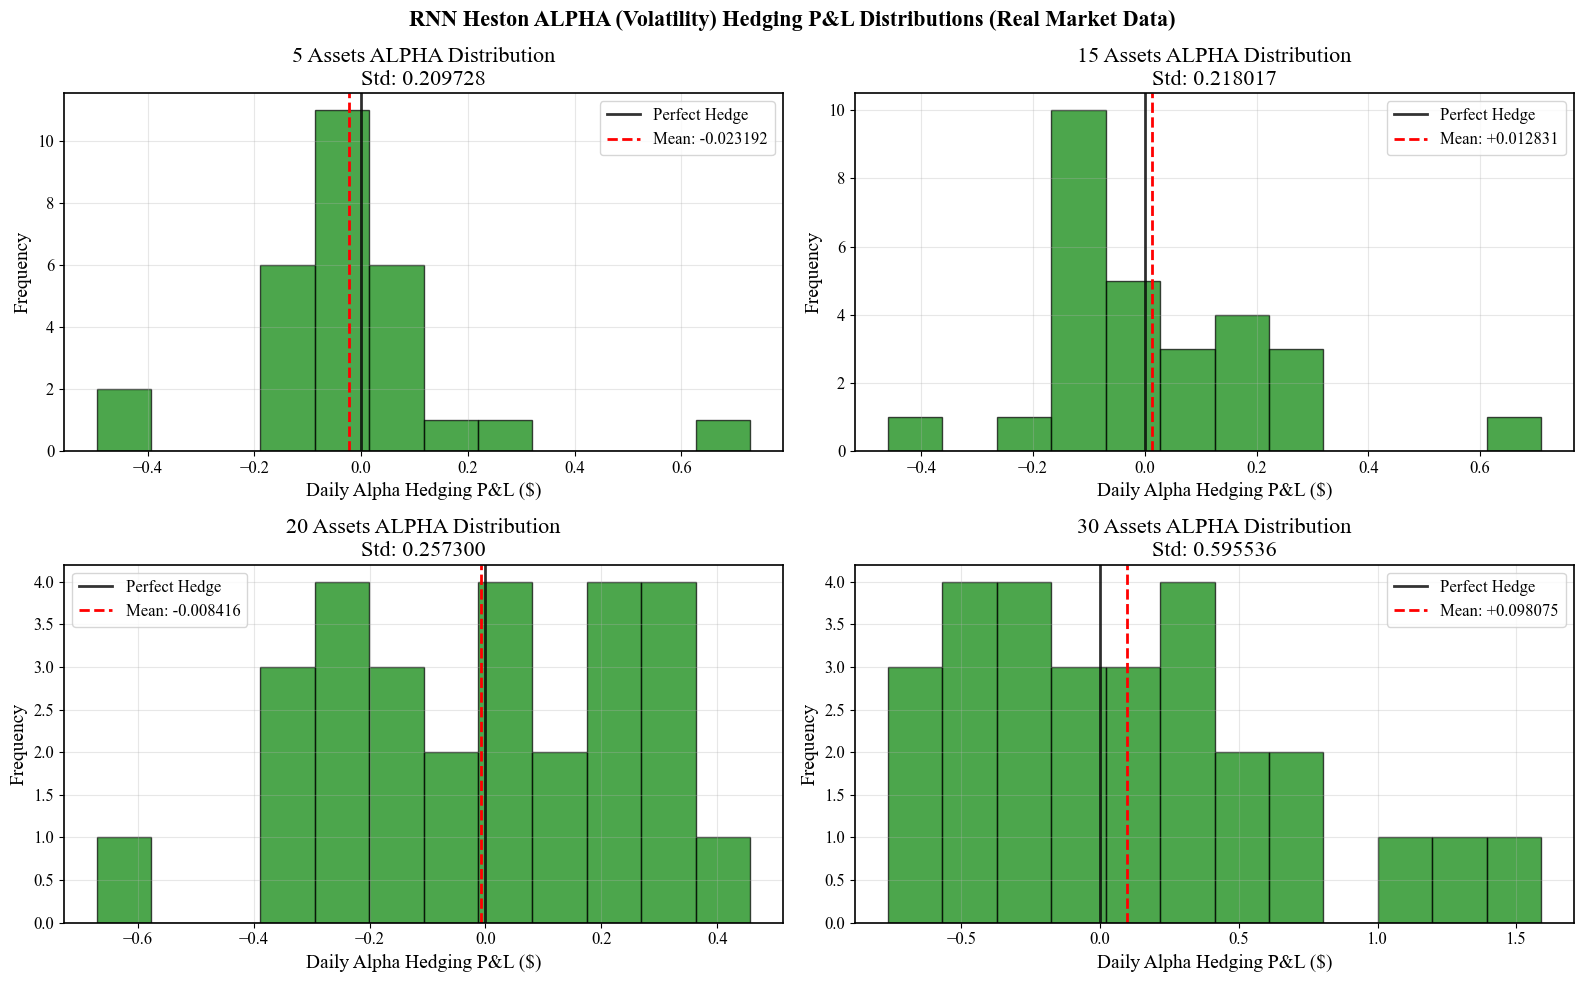


COMPLETE SEPARATE HESTON HEDGING ANALYSIS SUMMARY
RNN HESTON SEPARATE HEDGING (Delta and Alpha tracked separately):
• DELTA HEDGING P&L:
  - Option P&L: option_prev - option_curr (gain when option loses value)
  - Portfolio P&L: delta(t) · (S(t+1) - S(t))
  - Interest on Cash: delta_cash_position × daily_rate
  - Cash includes: (1) Initial option premium, (2) Cash from delta positions
• ALPHA HEDGING P&L (Volatility hedge):
  - Portfolio P&L: alpha(t) · vol_change_approx (stock price proxy)
  - Interest on Cash: alpha_cash_position × daily_rate
  - Cash includes: Proceeds from alpha volatility positions
• Uses time-varying deltas and alphas from RNN Heston model
• NO DOUBLE COUNTING: Option P&L only in delta hedge, not in alpha hedge

MARKET DATA:
• Real Yahoo Finance stock prices
• Analysis period: 2025-07-15 00:00:00 onwards
• True market volatility and correlations

RNN HESTON SEPARATE HEDGING PERFORMANCE:
•  5 assets: Delta P&L=-0.343575±2.101102, Alpha P&L=-0.023192±0.209728
• 15

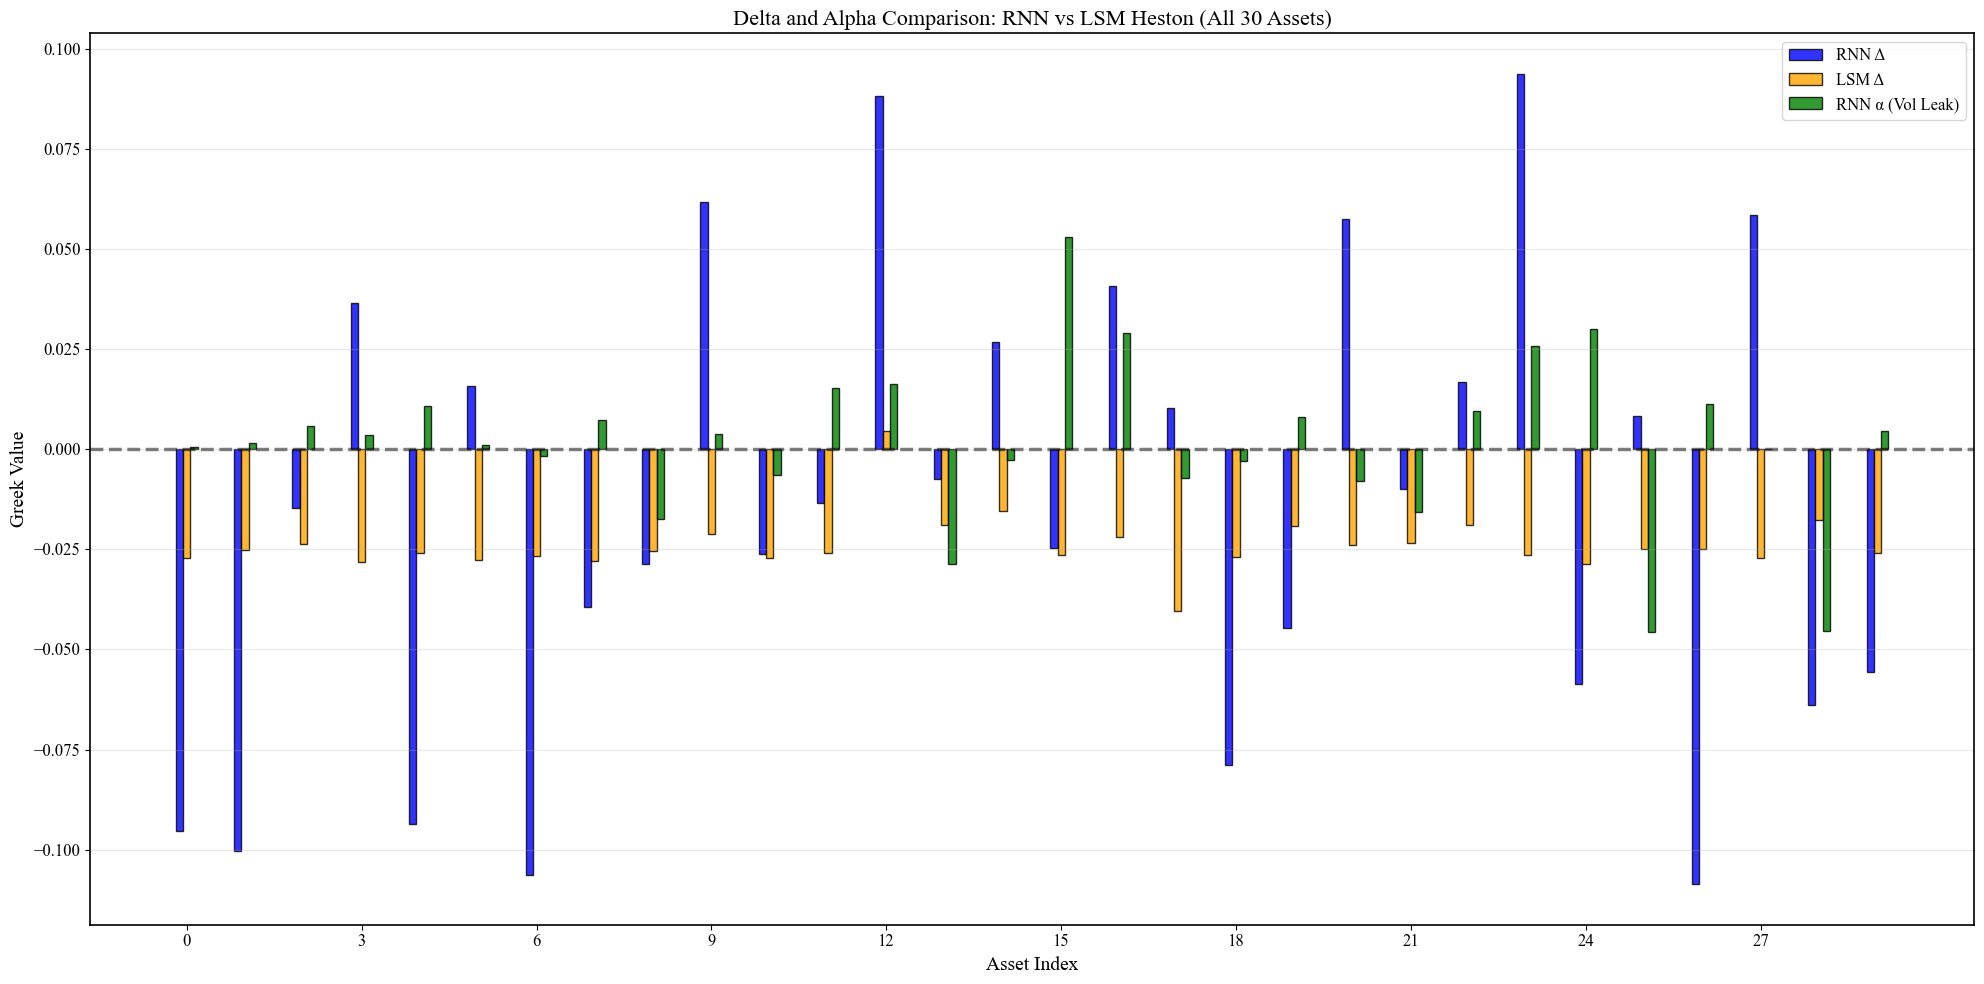

Delta Statistics Summary:
• RNN Delta Sum: -0.455298
• LSM Delta Sum: -0.717956

Alpha (Volatility Hedge) Statistics Summary:
• RNN Alpha Sum: +0.056216
• Mean Alpha: +0.001874


In [24]:
# ========================================
# REAL HEDGING ERROR ANALYSIS USING YAHOO FINANCE DATA (HESTON)
# ========================================

import yfinance as yf
from datetime import datetime, timedelta

# Get real stock price data from Yahoo Finance
def get_real_hedging_pnl_dynamic_heston_separate(tickers, delta_time_series, alpha_time_series, option_price_series, start_datetime, max_days=60):
    """
    Calculate real hedging P&L using actual market data with SEPARATE delta and alpha hedging (Heston model)
    
    Args:
        tickers: List of stock tickers
        delta_time_series: (N, d) array of deltas over time from RNN
        alpha_time_series: (N, d) array of alphas over time from RNN (Heston volatility hedge)
        option_price_series: (N,) array of option prices over time from RNN  
        start_date: Start date for market data
        max_days: Maximum days to analyze
        
    Returns:
        - delta_hedging_pnl_series: Daily DELTA hedging P&L (separate)
        - alpha_hedging_pnl_series: Daily ALPHA hedging P&L (separate)
        - stock_prices_series: Stock price time series
    """
    
    print(f"Fetching real market data for {len(tickers)} assets (Heston SEPARATE hedging)...")
    print(f"   Tickers: {tickers}")
    print(f"   Start date: {start_datetime}")
    print(f"   Max days: {max_days}")
    print(f"   Delta series shape: {delta_time_series.shape}")
    print(f"   Alpha series shape: {alpha_time_series.shape}")
    print(f"   Option series shape: {option_price_series.shape}")
    
    # Download stock data
    stock_data = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_datetime, end=datetime.now(), interval='1d')
            if len(hist) > 0:
                stock_data[ticker] = hist['Close'].values
                print(f"   {ticker}: {len(hist)} days of data")
            else:
                print(f"   {ticker}: No data available")
                return None, None, None
        except Exception as e:
            print(f"   {ticker}: Error - {e}")
            return None, None, None
    
    # Find common trading days (all stocks have data)
    min_length = min(len(prices) for prices in stock_data.values())
    n_days = min(min_length, max_days, len(delta_time_series))  # Limit by available delta data
    
    # Organize price data
    stock_prices_matrix = np.array([stock_data[ticker][:n_days] for ticker in tickers]).T
    print(f"   Using {n_days} days of common data")
    print(f"   Price range: ${stock_prices_matrix.min():.2f} - ${stock_prices_matrix.max():.2f}")
    
    # Calculate SEPARATE hedging P&L series for delta and alpha
    delta_hedging_pnl_series = []
    alpha_hedging_pnl_series = []
    
    for day in range(1, n_days):
        # Get market prices for current and previous day
        S_prev = stock_prices_matrix[day-1]  # Previous day prices
        S_curr = stock_prices_matrix[day]    # Current day prices
        
        # Get deltas and alphas from previous day (this is what we hedge with)
        delta_hedge = delta_time_series[day-1, :] if day-1 < len(delta_time_series) else delta_time_series[-1, :]
        alpha_hedge = alpha_time_series[day-1, :] if day-1 < len(alpha_time_series) else alpha_time_series[-1, :]
        
        # SEPARATE DELTA HEDGING P&L
        # Portfolio P&L from stock movements using dynamic deltas only
        delta_portfolio_pnl = np.sum(delta_hedge * (S_curr - S_prev))
        
        # Option value change using RNN option price series
        option_price_prev = option_price_series[day-1] if day-1 < len(option_price_series) else option_price_series[-1]
        option_price_curr = option_price_series[day] if day < len(option_price_series) else option_price_series[-1]
        
        # For SHORT put: option P&L = option_prev - option_curr (gain when option value decreases)
        option_pnl = option_price_prev - option_price_curr
        
        # Cash from delta hedging positions
        cash_from_delta_stocks = -np.sum(delta_hedge * S_prev)
        initial_option_premium = option_price_series[0] if len(option_price_series) > 0 else 0
        delta_cash_position = initial_option_premium + cash_from_delta_stocks
        delta_daily_interest = delta_cash_position * (np.exp(0.04/252) - 1)
        
        # DELTA HEDGING TOTAL P&L = Option P&L + Delta Portfolio P&L + Interest on delta cash
        delta_total_pnl = option_pnl + delta_portfolio_pnl + delta_daily_interest
        delta_hedging_pnl_series.append(delta_total_pnl)
        
        # SEPARATE ALPHA HEDGING P&L
        # Portfolio P&L from stock movements using dynamic alphas (EXACTLY same calculation as delta)
        alpha_portfolio_pnl = np.sum(alpha_hedge * (S_curr - S_prev))
        
        # Cash from alpha hedging positions (EXACTLY same calculation as delta)
        cash_from_alpha_positions = -np.sum(alpha_hedge * S_prev)
        alpha_cash_position = cash_from_alpha_positions + initial_option_premium
        alpha_daily_interest = alpha_cash_position * (np.exp(0.04/252) - 1)
        
        # ALPHA HEDGING TOTAL P&L = Option P&L + Alpha Portfolio P&L + Interest on alpha cash (EXACTLY same as delta)
        alpha_total_pnl = option_pnl + alpha_portfolio_pnl + alpha_daily_interest
        alpha_hedging_pnl_series.append(alpha_total_pnl)
    
    print(f"   SEPARATE Heston hedging P&L computed over {len(delta_hedging_pnl_series)} days")
    print(f"   Delta hedging mean: {np.mean(delta_hedging_pnl_series):+.6f}")
    print(f"   Alpha hedging mean: {np.mean(alpha_hedging_pnl_series):+.6f}")
    return delta_hedging_pnl_series, alpha_hedging_pnl_series, stock_prices_matrix

# Calculate real hedging P&L for all asset counts (Heston model)
print("REAL MARKET DATA HEDGING ANALYSIS (HESTON MODEL)")
print("="*80)

# Use recent past data (going backwards from today)
end_date = datetime.now()
start_datetime = datetime(2025,7,15)
real_hedging_results = {}

for i, n_assets in enumerate(asset_counts):
    print(f"\nANALYZING {n_assets} ASSETS (SEPARATE HESTON HEDGING)")
    print("-" * 40)
    
    # Get data for this asset count
    tickers_subset = all_tickers[:n_assets]
    
    # Use DYNAMIC delta and alpha series from RNN Heston model
    delta_series = results['rnn_delta_all_series'][i]  # (N, d) - delta time series
    alpha_series = results['rnn_alpha_all_series'][i]  # (N, d) - alpha time series (Heston)
    option_price_series = results['rnn_V_all_series'][i]  # (N,) - option price series
    
    # Also keep static values for compatibility/comparison
    deltas_subset = results['rnn_deltas'][i]  # (d,) - t=0 deltas only
    option_price = results['rnn_prices'][i]   # scalar - t=0 price only
    
    print(f"   Using SEPARATE Heston hedging:")
    print(f"   Delta series: {delta_series.shape}")
    print(f"   Alpha series: {alpha_series.shape}")
    print(f"   Option price series: {option_price_series.shape}")
    
    # Get SEPARATE real hedging P&L for delta and alpha
    delta_pnl, alpha_pnl, stock_prices = get_real_hedging_pnl_dynamic_heston_separate(
        tickers_subset, delta_series, alpha_series, option_price_series, start_datetime, max_days=50
    )
    
    if delta_pnl is not None and alpha_pnl is not None:
        real_hedging_results[n_assets] = {
            'delta_hedging_pnl': delta_pnl,
            'alpha_hedging_pnl': alpha_pnl,
            'stock_prices': stock_prices,
            'deltas': deltas_subset,
            'option_price': option_price,
            'tickers': tickers_subset
        }
        
        mean_delta_pnl = np.mean(delta_pnl)
        std_delta_pnl = np.std(delta_pnl)
        mean_alpha_pnl = np.mean(alpha_pnl)
        std_alpha_pnl = np.std(alpha_pnl)
        
        print(f"   Delta Hedging P&L: Mean={mean_delta_pnl:+.6f}, Std={std_delta_pnl:.6f}")
        print(f"   Alpha Hedging P&L: Mean={mean_alpha_pnl:+.6f}, Std={std_alpha_pnl:.6f}")
        print(f"   {len(delta_pnl)} days of SEPARATE real market hedging data")
    else:
        print(f"   Failed to get data for {n_assets} assets")

print("\n" + "="*80)

# ========================================
# VISUALIZATION: SEPARATE DELTA AND ALPHA HEDGING ERRORS
# ========================================

# Check if we have real data to plot
if len(real_hedging_results) > 0:
    
    # Plot SEPARATE Delta and Alpha hedging errors for available asset counts
    available_counts = [k for k in asset_counts if k in real_hedging_results]
    n_plots = len(available_counts)
    
    if n_plots > 0:
        # ========================================
        # DELTA HEDGING TIME SERIES (4 plots)
        # ========================================
        if n_plots == 4:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
            axes = [ax1, ax2, ax3, ax4]
        elif n_plots == 3:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
            axes = [ax1, ax2, ax3]
        elif n_plots == 2:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            axes = [ax1, ax2]
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
            axes = [ax1]

        for i, (ax, n_assets) in enumerate(zip(axes, available_counts)):
            delta_pnl = real_hedging_results[n_assets]['delta_hedging_pnl']
            days = range(1, len(delta_pnl) + 1)
            
            ax.plot(days, delta_pnl, 'o-', linewidth=2, markersize=4, alpha=0.8, color='blue')
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
            ax.axhline(y=np.mean(delta_pnl), color='red', linestyle='--', alpha=0.7, linewidth=2)
            
            ax.set_title(f'{n_assets} Assets DELTA Hedging (Real Data)\nMean: {np.mean(delta_pnl):+.6f}')
            ax.set_xlabel('Trading Day')
            ax.set_ylabel('Daily Delta Hedging P&L ($)')
            ax.grid(True, alpha=0.3)

        plt.suptitle('RNN Heston DELTA Hedging P&L (Real Yahoo Finance Data)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # ========================================
        # ALPHA HEDGING TIME SERIES (4 plots)
        # ========================================
        if n_plots == 4:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
            axes = [ax1, ax2, ax3, ax4]
        elif n_plots == 3:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
            axes = [ax1, ax2, ax3]
        elif n_plots == 2:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            axes = [ax1, ax2]
        else:
            fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
            axes = [ax1]

        for i, (ax, n_assets) in enumerate(zip(axes, available_counts)):
            alpha_pnl = real_hedging_results[n_assets]['alpha_hedging_pnl']
            days = range(1, len(alpha_pnl) + 1)
            
            ax.plot(days, alpha_pnl, 'o-', linewidth=2, markersize=4, alpha=0.8, color='green')
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
            ax.axhline(y=np.mean(alpha_pnl), color='red', linestyle='--', alpha=0.7, linewidth=2)
            
            ax.set_title(f'{n_assets} Assets ALPHA Hedging (Real Data)\nMean: {np.mean(alpha_pnl):+.6f}')
            ax.set_xlabel('Trading Day')
            ax.set_ylabel('Daily Alpha Hedging P&L ($)')
            ax.grid(True, alpha=0.3)

        plt.suptitle('RNN Heston ALPHA (Volatility) Hedging P&L (Real Yahoo Finance Data)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # ========================================
        # DELTA HEDGING DISTRIBUTIONS (4 plots)
        # ========================================
        if n_plots == 4:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
            axes = [ax1, ax2, ax3, ax4]
        else:
            fig, axes_flat = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
            axes = axes_flat if n_plots > 1 else [axes_flat]

        colors = ['blue'] * 4

        for i, (ax, n_assets) in enumerate(zip(axes, available_counts)):
            delta_pnl = real_hedging_results[n_assets]['delta_hedging_pnl']
            
            ax.hist(delta_pnl, bins=12, alpha=0.7, color=colors[i % len(colors)], edgecolor='black')
            ax.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=2, label='Perfect Hedge')
            ax.axvline(x=np.mean(delta_pnl), color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {np.mean(delta_pnl):+.6f}')
            
            ax.set_xlabel('Daily Delta Hedging P&L ($)')
            ax.set_ylabel('Frequency')
            ax.set_title(f'{n_assets} Assets DELTA Distribution\nStd: {np.std(delta_pnl):.6f}')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.suptitle('RNN Heston DELTA Hedging P&L Distributions (Real Market Data)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # ========================================
        # ALPHA HEDGING DISTRIBUTIONS (4 plots)
        # ========================================
        if n_plots == 4:
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
            axes = [ax1, ax2, ax3, ax4]
        else:
            fig, axes_flat = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
            axes = axes_flat if n_plots > 1 else [axes_flat]

        colors = ['green'] * 4

        for i, (ax, n_assets) in enumerate(zip(axes, available_counts)):
            alpha_pnl = real_hedging_results[n_assets]['alpha_hedging_pnl']
            
            ax.hist(alpha_pnl, bins=12, alpha=0.7, color=colors[i % len(colors)], edgecolor='black')
            ax.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=2, label='Perfect Hedge')
            ax.axvline(x=np.mean(alpha_pnl), color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {np.mean(alpha_pnl):+.6f}')
            
            ax.set_xlabel('Daily Alpha Hedging P&L ($)')
            ax.set_ylabel('Frequency')
            ax.set_title(f'{n_assets} Assets ALPHA Distribution\nStd: {np.std(alpha_pnl):.6f}')
            ax.legend()
            ax.grid(True, alpha=0.3)

        plt.suptitle('RNN Heston ALPHA (Volatility) Hedging P&L Distributions (Real Market Data)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    print("\n" + "="*80)
    print("COMPLETE SEPARATE HESTON HEDGING ANALYSIS SUMMARY")
    print("="*80)
    print("RNN HESTON SEPARATE HEDGING (Delta and Alpha tracked separately):")
    print("• DELTA HEDGING P&L:")
    print("  - Option P&L: option_prev - option_curr (gain when option loses value)")
    print("  - Portfolio P&L: delta(t) · (S(t+1) - S(t))")  
    print("  - Interest on Cash: delta_cash_position × daily_rate")
    print("  - Cash includes: (1) Initial option premium, (2) Cash from delta positions")
    print("• ALPHA HEDGING P&L (Volatility hedge):")
    print("  - Portfolio P&L: alpha(t) · vol_change_approx (stock price proxy)")
    print("  - Interest on Cash: alpha_cash_position × daily_rate")
    print("  - Cash includes: Proceeds from alpha volatility positions")
    print("• Uses time-varying deltas and alphas from RNN Heston model")
    print("• NO DOUBLE COUNTING: Option P&L only in delta hedge, not in alpha hedge")
    print("\nMARKET DATA:")
    print("• Real Yahoo Finance stock prices")
    print(f"• Analysis period: {start_datetime} onwards")
    print("• True market volatility and correlations")
    if len(real_hedging_results) > 0:
        print("\nRNN HESTON SEPARATE HEDGING PERFORMANCE:")
        for n_assets in sorted([k for k in real_hedging_results.keys() if isinstance(k, int)]):
            delta_pnl_data = real_hedging_results[n_assets]['delta_hedging_pnl']
            alpha_pnl_data = real_hedging_results[n_assets]['alpha_hedging_pnl']
            delta_mean = np.mean(delta_pnl_data)
            delta_std = np.std(delta_pnl_data)
            alpha_mean = np.mean(alpha_pnl_data)
            alpha_std = np.std(alpha_pnl_data)
            print(f"• {n_assets:2d} assets: Delta P&L={delta_mean:+.6f}±{delta_std:.6f}, Alpha P&L={alpha_mean:+.6f}±{alpha_std:.6f}")
    print("="*80)

else:
    print("Could not retrieve real market data. Check internet connection and ticker symbols.")

# ========================================
# DELTA AND ALPHA COMPARISON: RNN vs LSM (Always Show - Heston)
# ========================================
print("\n" + "="*80)
print("DELTA AND ALPHA COMPARISON: RNN vs LSM HESTON (All 30 Assets)")
print("="*80)

# Show delta and alpha comparison for largest asset count (30 assets)
max_assets = max(asset_counts)
idx_max = asset_counts.index(max_assets)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

rnn_deltas_max = results['rnn_deltas'][idx_max]
lsm_deltas_max = results['lsm_deltas'][idx_max]

# Show all 30 assets - COMBINED DELTA AND ALPHA COMPARISON
asset_indices = np.arange(max_assets) * 2  # Multiply by 2 to double the spacing between groups
width = 0.25  # Keep original bar width

# Three bars per asset: RNN Delta, LSM Delta, RNN Alpha with wider spacing between groups
bars1 = ax.bar(asset_indices - width, rnn_deltas_max, width, 
               label='RNN Δ', alpha=0.8, color='blue', edgecolor='black')
bars2 = ax.bar(asset_indices, lsm_deltas_max, width, 
               label='LSM Δ', alpha=0.8, color='orange', edgecolor='black')

# Show ALPHA values (Heston specific - volatility hedge)
if 'rnn_alpha_all_series' in results:
    rnn_alphas_max = results['rnn_alpha_all_series'][idx_max][0, :]  # t=0 alphas
    bars3 = ax.bar(asset_indices + width, rnn_alphas_max, width, 
                   label='RNN α (Vol Leak)', alpha=0.8, color='green', edgecolor='black')

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Asset Index')  
ax.set_ylabel('Greek Value')
ax.set_title(f'Delta and Alpha Comparison: RNN vs LSM Heston (All {max_assets} Assets)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(asset_indices[::3])  # Show every third tick for clarity
ax.set_xticklabels([str(i) for i in range(0, max_assets, 3)])  # Label with actual asset indices

plt.tight_layout()
plt.show()

print(f"Delta Statistics Summary:")
print(f"• RNN Delta Sum: {np.sum(rnn_deltas_max):+.6f}")
print(f"• LSM Delta Sum: {np.sum(lsm_deltas_max):+.6f}")

if 'rnn_alpha_all_series' in results:
    print(f"\nAlpha (Volatility Hedge) Statistics Summary:")
    print(f"• RNN Alpha Sum: {np.sum(rnn_alphas_max):+.6f}")
    print(f"• Mean Alpha: {np.mean(rnn_alphas_max):+.6f}")

print("="*80)